# CS5814: Assignment 1

## Problem 1

### Imports and config

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Supressing Jupyter Notebook torchvision installation error 

import torchvision as thv
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
RANDOM_SEED = 525

### (a) Downloading data [5]

MNIST data is first downloaded, before 50% of both training and test data is discarded - resulting in 30,000 and 5,000 test and training isntances respectively.

In [2]:
def download_data(print_size=False, retention_ratio=0.5):
    """
    Will download MNIST dataset - if not currently located within ../data
    :return: train, val datasets
    """
    
    np.random.seed(RANDOM_SEED)

    
    train = thv.datasets.MNIST('', download=True, train=True)
    test = thv.datasets.MNIST('', download=True, train=False)
    
    if print_size:
        print("Data shapes prior to discarding:\n")
        print("Training:")
        print("Data: {}, Labels: {}".format(train.train_data.shape, train.train_labels.shape))  # Note this needed some alterations to run in Jupyter
        print("Test:")
        print("Data: {}, Labels: {}".format(test.test_data.shape, test.test_labels.shape))  # Note this needed some alterations to run in Jupyter
        print("=================================\n")

    #return train, val

    train_image = train.train_data.numpy()
    train_label = train.train_labels.numpy()
    test_image = test.test_data.numpy()
    test_label = test.test_labels.numpy()
    
    np.random.seed(RANDOM_SEED)
        
    idx_train = np.random.choice(np.arange(len(train_image)), int(len(train_image)*retention_ratio), replace=False)
    idx_test = np.random.choice(np.arange(len(test_image)), int(len(test_image)*retention_ratio), replace=False)
    
    train_image = train_image[idx_train]
    train_label = train_label[idx_train]

    test_image = test_image[idx_test]
    test_label = test_label[idx_test]

    if print_size:
        print("Data shapes following discarding and numpy conversion:\n")
        print("Training:")
        print("Data: {}, Labels: {}".format(train_image.shape, train_label.shape))  # Note this needed some alterations to run in Jupyter
        print("Test:")
        print("Data: {}, Labels: {}".format(test_image.shape, test_label.shape))  # Note this needed some alterations to run in Jupyter
        print("=================================\n")

    
    
    return train_image, train_label, test_image, test_label
    
train_image, train_label, test_image, test_label= download_data(print_size=True)


Data shapes prior to discarding:

Training:
Data: torch.Size([60000, 28, 28]), Labels: torch.Size([60000])
Test:
Data: torch.Size([10000, 28, 28]), Labels: torch.Size([10000])

Data shapes following discarding and numpy conversion:

Training:
Data: (30000, 28, 28), Labels: (30000,)
Test:
Data: (5000, 28, 28), Labels: (5000,)



### (b) Linear Layer [20]

In [3]:
class LinearLayerT:
    def __init__(self, input_size=784, width=10, batch_size=1):

        self.width = width
        self.input_size = input_size

        # Init weights and bias to appropriate sizes, fill via sampling from Gaussian dist
        self.w = np.random.normal(loc=0.0, scale=1.0,
                                  size=(self.width, self.input_size))
        self.b = np.random.normal(loc=0.0, scale=1.0, size=(self.width))

        # Normalize everything such that L2 norm of w, b = 1
        for neuron_id in range(width):
            self.w[neuron_id] = self.w[neuron_id] / np.linalg.norm(self.w[neuron_id], ord=2)
        self.b = self.b / np.linalg.norm(self.b, ord=2)

        # Initalize arrays for gradident calulations
        self.a_l_prior = np.zeros((self.width, self.input_size))
        self.dw = np.zeros((self.width, self.input_size))
        self.db = np.zeros((self.width))

    def forward(self, a_l_prior):
        # Calculate forward pass step for layer
        
        self.a_l_prior = a_l_prior.reshape(a_l_prior.shape[0], -1)  # Converts image into 1D vector
        z_l = np.matmul(self.a_l_prior, self.w.transpose()) + self.b  # wX+b

        return z_l

    def backward(self, da_l):
        # Calculate back prop step for layer
        
        self.dw = np.matmul(da_l.transpose(), self.a_l_prior) / da_l.shape[0]
        self.db = np.sum(da_l, axis=0) / da_l.shape[0]
        da_l_prior = self.dw

        return da_l_prior

    def zero_grad(self):
        # Zeros backprop grads of prior mini-batch
        
        self.dw, self.db = 0 * self.dw, 0 * self.db

### (c) Rectified Linear Unit [10]

In [4]:
class ReLU:
    def __init__(self):
        self.a_l_prior = 0

    def forward(self, a_l_prior):
        # Calculate forward pass step for layer

        self.a_l_prior = a_l_prior
        return a_l_prior * (a_l_prior > 0)

    def backward(self, da_l):
        # Calculate back prop step for layer

        return da_l * (1 * (self.a_l_prior > 0))

### (d) Softmax and cross-entropy loss layer [10]

In [5]:
class SoftmaxCrossEntropyT:
    def __init__(self):
        pass

    def forward(self, z_l_prior, y):    

        batch_size = z_l_prior.shape[0]

        # Determining predictions
        y_hat = np.exp(z_l_prior) / np.sum(np.exp(z_l_prior), axis=1).reshape(batch_size, 1)
        predictions = np.argmax(y_hat, axis=1)
        
        accuracy = np.sum(np.argmax(y, axis=1) == np.argmax(y_hat, axis=1)) / batch_size

        # Cross entropy loss averaged over mini batch
        cross_entropy_loss = -np.sum(y * np.log(y_hat)) / batch_size

        self.dz_l_prior = y_hat - y

        return cross_entropy_loss, accuracy

    def backward(self):
        return self.dz_l_prior

### (e) Verify network with batch size = 1 [5]

In order to verify the functionality of the network - a single epoch of training is conducted to ensure data can be accuractly passed both forward and backward through the network.

The remaining functions used for training and visulization are definined below (Validation, Training loop, and output ploter)

### Validation

In [6]:
def validate(l1, l2, l3, test_image, test_label):
    # Conducting validation in a single batch as memory allows it

    # Loading and normalizing images
    x, y = test_image, test_label
    x = x / 255

    # One hot encoding
    y_one_hot = np.zeros((y.size, 10))
    y_one_hot[np.arange(y.size), y] = 1

    # Forward pass
    a1 = l1.forward(x)
    a2 = l2.forward(a1)
    loss, accuracy = l3.forward(a2, y_one_hot)

    return loss, accuracy

### Training loop

In [7]:
def training(epochs = 20, learning_rate = 0.01, validate_data=False, batch_size=1, generate_plots=True):
    
    # Loading data
    train_image, train_label, test_image, test_label = download_data()
    np.random.seed(RANDOM_SEED)

    # Constucting network (Linear -> ReLU -> Softmax)
    l1, l2, l3 = LinearLayerT(batch_size=batch_size), ReLU(), SoftmaxCrossEntropyT()
    
    # Initalize for tracking metrics over training
    t_ts = []
    loss_ts = []
    val_loss_ts = []
    val_accuracy_ts = []
    update_counter = 0

    
    train_error_array = []
    train_loss_array = []
    train_loss_smooth_array = []
    mini_batch_error_array = []
    
    val_weight_update_array = []
    val_error_array = []
    val_loss_array = []
    
    
    
    for e in range(epochs):
        
        # random indexes to ensure batches are randomized per epoch        
        idx = np.random.choice(np.arange(len(train_image)), len(train_image), replace=False)
        
        # TODO - what are these specifically? Rename
        count = 0
        loss = 0
        epoch_accuracy = 0
        
        for mini_batch_id, i in enumerate(range(0, train_image.shape[0], batch_size)):
            count += 1
            
            # Zero prior grad calculations
            l1.zero_grad()
            
            # Sample random mini batch ids and normalize input images (0-1)            
            x = train_image[idx[i:i + batch_size]] / 255
            y = train_label[idx[i:i + batch_size]]
            
            # One hot encoding
            y_one_hot = np.zeros((y.size, 10))
            y_one_hot[np.arange(y.size), y] = 1

            # Forward pass
            a1 = l1.forward(x)
            a2 = l2.forward(a1)
            loss_local, accuracy = l3.forward(a2, y_one_hot)
            epoch_accuracy += accuracy
            loss += loss_local

            # Backward pass
            da2 = l3.backward()
            da1 = l2.backward(da2)
            dx = l1.backward(da1)

            # Update weights and bias
            l1.w = l1.w - learning_rate * l1.dw
            l1.b = l1.b - learning_rate * l1.db
            update_counter += 1
            
            
            train_loss_array.append(loss_local)
            avg_loss = np.average(train_loss_array[-100:])
            
            train_loss_smooth_array.append(avg_loss)
            mini_batch_error_array.append(1-accuracy)
            avg_train_error = np.average(mini_batch_error_array[-100:])
            train_error_array.append(avg_train_error)

            
            if mini_batch_id % 100 == 0:
                val_loss, val_accuracy = validate(l1, l2, l3, test_image, test_label)
                val_loss_ts.append(val_loss)
                
                
                val_accuracy_ts.append(val_accuracy)
                
                
                train_loss_smooth_array
                val_weight_update_array.append(update_counter)
                val_error_array.append(1-val_accuracy)
                val_loss_array.append(val_loss)
                
        if validate_data:
            print("Epoch: {}, Weight updates: {}, "
                  "Train_loss: {:.4f}, Train_error: {:.4f}, "
                  "Val_loss: {:.4f}, Val_error: {:.4f}".format(e,
                                                      update_counter,
                                                      avg_loss,
                                                      avg_train_error,
                                                      val_loss,
                                                      1-val_accuracy))


        else:
             print("Epoch: {}, Weight updates: {}, "
                  "Train_loss: {:.4f}, Train_error: {:.4f}, ".format(e,
                                                      update_counter,avg_loss,
                                                      avg_train_error))
                                                                            
    
    if generate_plots:
        q1_plot((train_error_array,
                 mini_batch_error_array,
                 train_loss_array,
                 train_loss_smooth_array,
                 val_error_array,
                 val_loss_array,
                 val_weight_update_array), validate_data)

### Output plotter

In [8]:
def q1_plot(data, plot_validation=True):
    train_error_array,mini_batch_error_array, train_loss_array,train_loss_smooth_array, val_error_array, val_loss_array, val_weight_update_array = data
        
    fig, axs = plt.subplots(2,1)
    fig.set_size_inches(12, 16)
    
    fig.tight_layout(rect=[0, 0.08, 1, 0.98])
    fig.subplots_adjust(hspace = 0.2)

    
    axs[0].plot(mini_batch_error_array, alpha=0.8, label="Training [minibatch]")
    axs[0].plot(train_error_array, linewidth=3, color="red", label="Training [averaged]")
    
    if plot_validation:
        axs[0].plot(val_weight_update_array, val_error_array, linewidth=3, color="black", label="Validation")
    axs[0].legend(loc="upper right")
    axs[0].set_title("Model Error")
    axs[0].set_xlabel("Weight update")
    axs[0].set_ylabel("Classification Error")

    axs[0].grid()
    #plt.show()

    axs[1].plot(train_loss_array, alpha=0.8, label="Training [minibatch]")
    axs[1].plot(train_loss_smooth_array, linewidth=3, color="red", label="Training [averaged]")
    if plot_validation:
        axs[1].plot(val_weight_update_array, val_loss_array, linewidth=3, color="black", label="Validation")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Model Loss")
    axs[1].set_xlabel("Weight update")
    axs[1].set_ylabel("Loss")
    axs[1].grid()

In [9]:
training(epochs=1, learning_rate = 0.1, validate_data=False, batch_size=1, generate_plots=False)

Epoch: 0, Weight updates: 30000, Train_loss: 1.5159, Train_error: 0.6300, 


### (f) Train network and generate loss plots [5]

Note that the averaged training data in red is calculated based on the previous 100 minibatch data points.

Epoch: 0, Weight updates: 938, Train_loss: 0.5987, Train_error: 0.1984, 
Epoch: 1, Weight updates: 1876, Train_loss: 0.5887, Train_error: 0.2028, 
Epoch: 2, Weight updates: 2814, Train_loss: 0.4106, Train_error: 0.1138, 
Epoch: 3, Weight updates: 3752, Train_loss: 0.2957, Train_error: 0.0809, 
Epoch: 4, Weight updates: 4690, Train_loss: 0.3108, Train_error: 0.0912, 


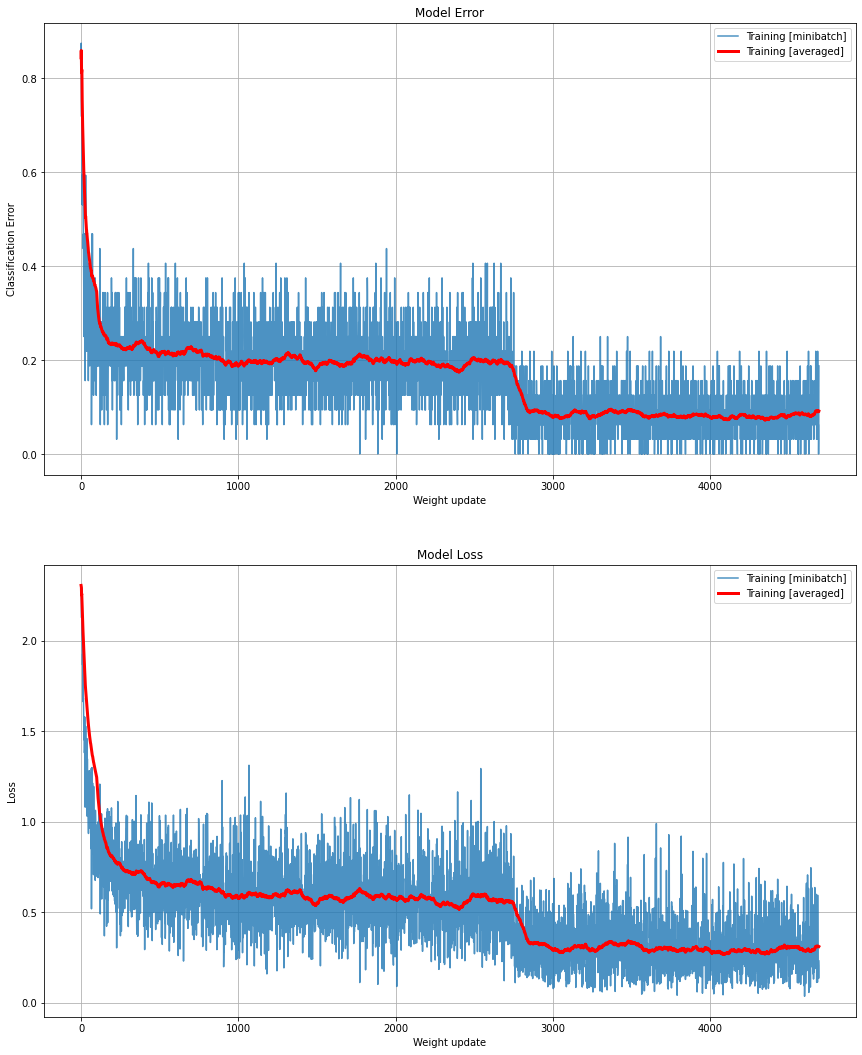

In [10]:
training(epochs=5, learning_rate = 0.1, validate_data=False, batch_size=32)

### (g) Train network with validation metics [10]

Validation metics are conducted every 100 mini batches within training

Epoch: 0, Weight updates: 938, Train_loss: 0.5987, Train_error: 0.1984, Val_loss: 0.6031, Val_error: 0.2002
Epoch: 1, Weight updates: 1876, Train_loss: 0.5887, Train_error: 0.2028, Val_loss: 0.5705, Val_error: 0.1956
Epoch: 2, Weight updates: 2814, Train_loss: 0.4106, Train_error: 0.1138, Val_loss: 0.3454, Val_error: 0.0892
Epoch: 3, Weight updates: 3752, Train_loss: 0.2957, Train_error: 0.0809, Val_loss: 0.3021, Val_error: 0.0838
Epoch: 4, Weight updates: 4690, Train_loss: 0.3108, Train_error: 0.0912, Val_loss: 0.3015, Val_error: 0.0858


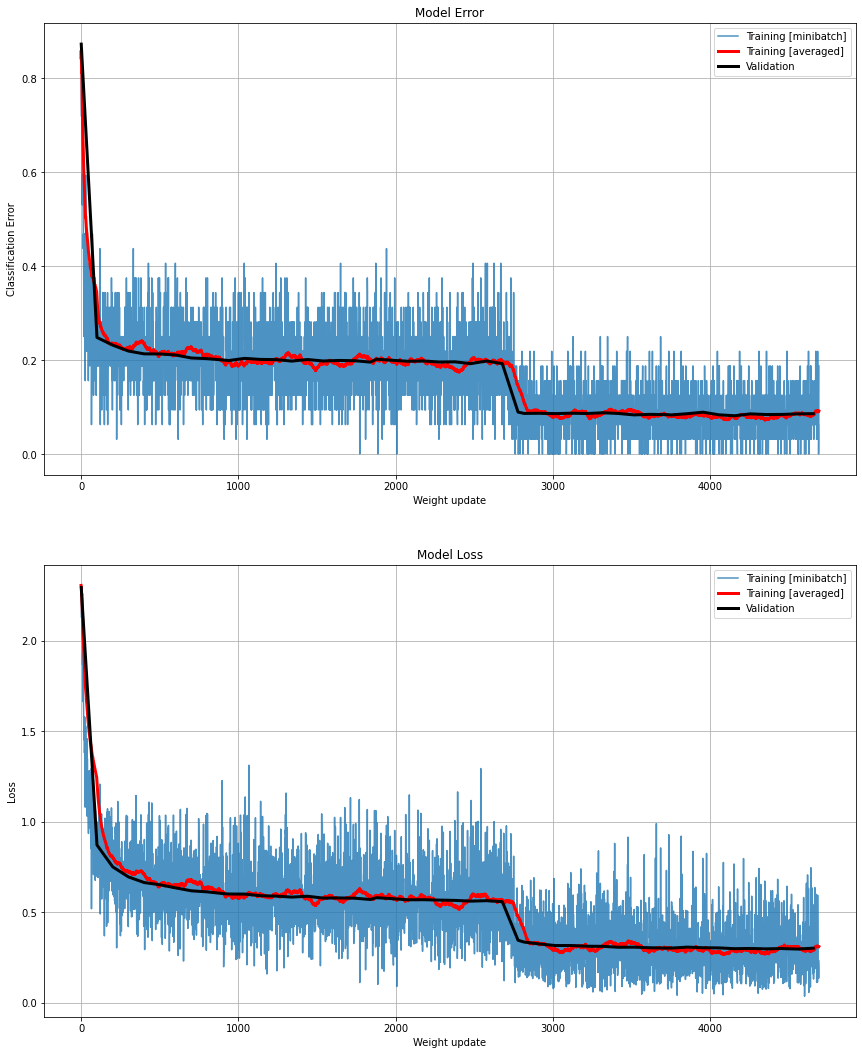

In [11]:
training(epochs=5, learning_rate = 0.1, validate_data=True, batch_size=32)